In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import progressbar
import torch
import tensorflow as tf
from pathlib import Path
from matplotlib import pyplot as plt, image as img
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, Conv2DTranspose, MaxPool2D, ReLU, Flatten, Dense,
    UpSampling2D, Dropout, Input, Concatenate, GlobalAveragePooling2D, GlobalMaxPooling2D
)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(3)
tf.random.set_seed(7)

# Load the dataset

In [ ]:
def load_raw_data():
    covid_path = "/content/drive/MyDrive/COVID-19/data/curated_data/curated_data/2COVID"
    non_covid_path = "/content/drive/MyDrive/COVID-19/data/curated_data/curated_data/1NonCOVID"
    cap_path = "/content/drive/MyDrive/COVID-19/data/curated_data/curated_data/3CAP"


    covid_images = list(Path(covid_path).glob("*.png"))
    non_covid_images = list(Path(non_covid_path).glob("*.png"))
    cap_images = list(Path(cap_path).glob("*.png"))
    
    # To visualize the dataset
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    image = img.imread(covid_images[1])
    plt.imshow(image)
    plt.title("CT Scan of Covid Affected Lungs")

    fig.add_subplot(1, 2, 2)
    image = img.imread(non_covid_images[1])
    plt.imshow(image)
    plt.title("CT Scan of Healthy Lungs")
    return covid_images, non_covid_images, cap_images

7593
6893
2618


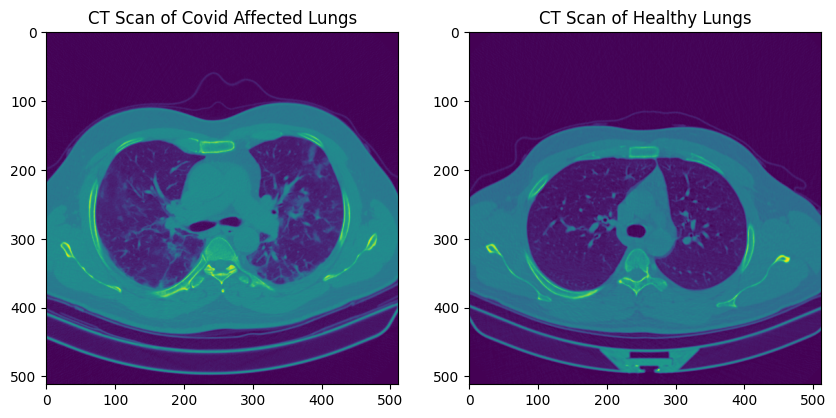

In [ ]:
covid_images, non_covid_images, cap_images = load_raw_data()

print(len(covid_images))
print(len(non_covid_images))
print(len(cap_images))

# Data Preprocessing

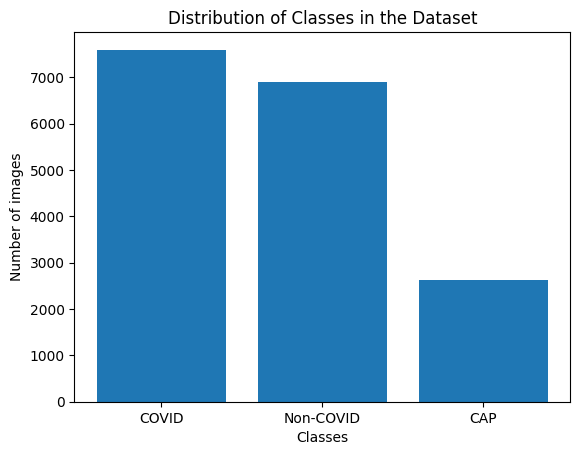

In [ ]:
import matplotlib.pyplot as plt

# Histogram of the number of images in each class
fig, ax = plt.subplots()
class_names = ['COVID', 'Non-COVID', 'CAP']
class_counts = [len(covid_images), len(non_covid_images), len(cap_images)]
ax.bar(class_names, class_counts)
ax.set_xlabel('Classes')
ax.set_ylabel('Number of images')
ax.set_title('Distribution of Classes in the Dataset')
plt.show()

In [ ]:
IMG_SIZE = 64

# Three empty numpy arrays to store coverted images
covid_npy = np.empty((len(covid_images), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
non_covid_npy = np.empty((len(non_covid_images), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
cap_npy = np.empty((len(cap_images), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

# start a bar of show percentage of loading data 
covid_bar = progressbar.ProgressBar(maxval=len(covid_images), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
non_covid_bar = progressbar.ProgressBar(maxval=len(non_covid_images), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
cap_bar = progressbar.ProgressBar(maxval=len(cap_images), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])


In [ ]:
covid_bar.start()
# Converting COVID dataset to .npy format
for i, _file in enumerate(covid_images):
    try:
        image_npy = img.imread(_file)
        positive = resize(image_npy, (IMG_SIZE, IMG_SIZE, 1), anti_aliasing=True)
        covid_npy[i] = positive
    except:
        pass
    covid_bar.update(i+1)
    
covid_bar.finish()
print("COVID images converting done")

[========================================================================] 100%


COVID images converting done


In [ ]:
non_covid_bar.start()
# Converting non-COVID dataset to .npy format
for i, _file in enumerate(non_covid_images):
    try:
        image_npy = img.imread(_file)
        negative = resize(image_npy, (IMG_SIZE, IMG_SIZE, 1), anti_aliasing=True)
        non_covid_npy[i] = negative
    except:
        print("cant open image " + i + "th") 
        
    non_covid_bar.update(i+1)
non_covid_bar.finish()
print("non covid images converting done")    

[========================================================================] 100%


non covid images converting done


In [ ]:
cap_bar.start()
# Converting non-COVID dataset to .npy format
for i, _file in enumerate(cap_images):
    try:
        image_npy = img.imread(_file)
        cap = resize(image_npy, (IMG_SIZE, IMG_SIZE, 1), anti_aliasing=True)
        cap_npy[i] = cap
    except:
        print("cant open image " + i + "th") 
        
    cap_bar.update(i+1)
cap_bar.finish()
print("cap images converting done") 

[========================================================================] 100%


cap images converting done


In [ ]:
import os
save_dir = "/content/drive/MyDrive/COVID-19/npy_files/"

# Check if the save directory exists, if not create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
# Save the numpy arrays to disk
np.save(os.path.join(save_dir, "covid_npy.npy"), covid_npy)
np.save(os.path.join(save_dir, "non_covid_npy.npy"), non_covid_npy)
np.save(os.path.join(save_dir, "cap_npy.npy"), cap_npy)

In [ ]:
# Load the numpy arrays from disk
covid_npy = np.load(os.path.join(save_dir, "covid_npy.npy"))
non_covid_npy = np.load(os.path.join(save_dir, "non_covid_npy.npy"))
cap_npy = np.load(os.path.join(save_dir, "cap_npy.npy"))

In [ ]:
print(covid_npy.shape)
print(non_covid_npy.shape)
print(cap_npy.shape)

(7593, 64, 64, 1)
(6893, 64, 64, 1)
(2618, 64, 64, 1)


# Loading and splitting the processed data

In [ ]:
def load_data():
    cap = cap_npy
    cap_labels = [2 for i in cap]
    positive = covid_npy
    positive_labels = [1 for i in positive]
    negative = non_covid_npy
    negative_labels = [0 for i in negative]

    # Joining both datasets and labels
    X = np.concatenate([positive, negative, cap])
    y = np.concatenate([positive_labels, negative_labels, cap_labels])

    # # Divide data into 10% labeled and 90% unlabeled
    # X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.9, stratify=y, random_state=42)
    
    # Divide data into 10% labeled and 90% unlabeled
    X_unlabeled, X_labeled, y_unlabeled, y_labeled = train_test_split(X, y, test_size=0.9, stratify=y, random_state=42)

    # Divide the labeled data randomly into two disjoint subsets A and B
    subset_a, subset_b, y_a, y_b = train_test_split(X_labeled, y_labeled, test_size=0.5, stratify=y_labeled, random_state=42)
    
    return X_unlabeled,y_unlabeled, subset_a, subset_b, y_a, y_b, X, y

In [ ]:
# Load the data
X_unlabeled,y_unlabeled, subset_a, subset_b, y_a, y_b, X, y = load_data()

# visualization

In [ ]:
# Print the shapes
print("X_unlabeled shape:", X_unlabeled.shape)
print("subset_a shape:", subset_a.shape)
print("subset_b shape:", subset_b.shape)
print("y_a shape:", y_a.shape)
print("y_b shape:", y_b.shape)
print("X shape:", X.shape)
print("y shape:", y.shape)

X_unlabeled shape: (1710, 64, 64, 1)
subset_a shape: (7697, 64, 64, 1)
subset_b shape: (7697, 64, 64, 1)
y_a shape: (7697,)
y_b shape: (7697,)
X shape: (17104, 64, 64, 1)
y shape: (17104,)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Swav Model

In [ ]:
model_swav=torch.hub.load('facebookresearch/swav:main', 'resnet50')
torch.save(model_swav.state_dict(), '/content/drive/MyDrive/COVID-19/models/model_swav.pt')

Downloading: "https://github.com/facebookresearch/swav/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://dl.fbaipublicfiles.com/deepcluster/swav_800ep_pretrain.pth.tar" to /root/.cache/torch/hub/checkpoints/swav_800ep_pretrain.pth.tar
100%|██████████| 108M/108M [00:00<00:00, 172MB/s]


# Define the model

In [ ]:
def create_swav_model():
    model = torch.hub.load('facebookresearch/swav:main', 'resnet50')
    model.classifier = keras.layers.Dense(3, activation='softmax')
    model.to(device)
    return model

In [ ]:
import torch.nn as nn
C1 = create_swav_model()
C2 = create_swav_model()

Using cache found in /root/.cache/torch/hub/facebookresearch_swav_main
Using cache found in /root/.cache/torch/hub/facebookresearch_swav_main


# Train model ()

In [ ]:
def train_model(model, data, target):
    data_rgb = np.repeat(data, 3, axis=-1)  # Convert grayscale to RGB
    data, target = torch.from_numpy(data_rgb).float().to(device).permute(2, 0, 1), torch.tensor(target).long().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    optimizer.zero_grad()
    output = model(data.unsqueeze(0))
    loss = criterion(output, target.unsqueeze(0))
    loss.backward()
    optimizer.step()
    return model

# Train and update

In [ ]:
def train_and_update(C1, C2, X_unlabeled, subset_a, subset_b, y_a, y_b, threshold=0.5, max_iter=100):
    iteration = 0
    while iteration < max_iter:
        iteration += 1
        print(f"Iteration: {iteration}")

        for epoch in range(5):
            print(f"Training epoch {epoch + 1}")
            for data_a, target_a in zip(subset_a, y_a):
                C1 = train_model(C1, data_a, target_a)

            for data_b, target_b in zip(subset_b, y_b):
                C2 = train_model(C2, data_b, target_b)

        # Evaluate the models on the labeled data and the entire dataset
        print("Subset A accuracy:", C1.evaluate(subset_a, y_a)[1])
        print("Subset B accuracy:", C2.evaluate(subset_b, y_b)[1])
        print("X_unlabeled accuracy:", (C1.predict(X_unlabeled).argmax(axis=-1) == C2.predict(X_unlabeled).argmax(axis=-1)).mean())

        # Label the unlabeled data based on the consistency and confidence of the two classifiers' predictions
        for i, data in enumerate(X_unlabeled):
            pred_c1 = C1(torch.from_numpy(np.repeat(data, 3, axis=-1)).float().to(device).unsqueeze(0).permute(0, 3, 1, 2)).cpu().detach().numpy()
            pred_c2 = C2(torch.from_numpy(np.repeat(data, 3, axis=-1)).float().to(device).unsqueeze(0).permute(0, 3, 1, 2)).cpu().detach().numpy()

            if np.argmax(pred_c1) == np.argmax(pred_c2):
                y_unlabeled[i] = np.argmax(pred_c1)
            else:
                if np.max(pred_c1) > np.max(pred_c2):
                    y_unlabeled[i] = np.argmax(pred_c1)
                else:
                    y_unlabeled[i] = np.argmax(pred_c2)

        # Select samples with high confidence and update the dataset
        high_confidence_b = np.max(pred_b, axis=1) > threshold
        high_confidence_a = np.max(pred_a, axis=1) > threshold

        if not np.any(high_confidence_a) and not np.any(high_confidence_b):
            break
        print(f"Selected {np.sum(high_confidence_b)} samples from subset B")
        print(f"Selected {np.sum(high_confidence_a)} samples from subset A")
        
        # Move the samples that have been labeled as correctly classified from one subset to another (cross-placement)
        subset_a_labeled = np.concatenate([subset_b[i][np.newaxis] for i, hc in enumerate(high_confidence_b) if hc])
        subset_b_labeled = np.concatenate([subset_a[i][np.newaxis] for i, hc in enumerate(high_confidence_a) if hc])
        y_a_labeled = np.concatenate([y_b[i][np.newaxis] for i, hc in enumerate(high_confidence_b) if hc])
        y_b_labeled = np.concatenate([y_a[i][np.newaxis] for i, hc in enumerate(high_confidence_a) if hc])

        # Update the labeled data in the subsets
        subset_a = np.concatenate([subset_a, subset_b_labeled])
        subset_b = np.concatenate([subset_b, subset_a_labeled])
        y_a = np.concatenate([y_a, y_b_labeled])
        y_b = np.concatenate([y_b, y_a_labeled])

        # Remove the labeled samples from the unlabeled dataset
        X_unlabeled = np.delete(X_unlabeled, np.where(high_confidence_a | high_confidence_b)[0], axis=0)
        y_unlabeled = np.delete(y_unlabeled, np.where(high_confidence_a | high_confidence_b)[0], axis=0)

    return C1, C2

In [ ]:
# Train the models and get the final classifiers
C1_final, C2_final = train_and_update(C1, C2, X_unlabeled, subset_a, subset_b, y_a, y_b)

Iteration: 1
Training epoch 1


In [ ]:
# Save the final trained models
model_dir = "/content/drive/MyDrive/COVID-19/models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path1 = os.path.join(model_dir, "trained_swav_model1_final.pth")
torch.save(C1_final, model_path1)

model_path2 = os.path.join(model_dir, "trained_swav_model2_final.pth")
torch.save(C2_final, model_path2)

In [ ]:
def predict_unlabeled_data(X_unlabeled, C1_final, C2_final, threshold=0.5):
    # Get the predictions for the unlabeled data from both classifiers
    C1_pred = np.array([C1_final(torch.from_numpy(np.repeat(data, 3, axis=-1)).float().to(device).unsqueeze(0).permute(0, 3, 1, 2)).cpu().detach().numpy() for data in X_unlabeled])
    C2_pred = np.array([C2_final(torch.from_numpy(np.repeat(data, 3, axis=-1)).float().to(device).unsqueeze(0).permute(0, 3, 1, 2)).cpu().detach().numpy() for data in X_unlabeled])

    # Initialize an array for the final labels
    final_labels = np.zeros(X_unlabeled.shape[0])

    # Iterate over the predictions and determine the label based on the consistency between classifiers and the confidence threshold
    for i, (pred1, pred2) in enumerate(zip(C1_pred, C2_pred)):
        if np.argmax(pred1) == np.argmax(pred2):
            final_labels[i] = np.argmax(pred1)
        else:
            if np.max(pred1) > np.max(pred2) and np.max(pred1) > threshold:
                final_labels[i] = np.argmax(pred1)
            elif np.max(pred2) > threshold:
                final_labels[i] = np.argmax(pred2)

    return final_labels

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# Predict the labels for the unlabeled data using the predict_unlabeled_data function
unlabeled_labels = predict_unlabeled_data(X_unlabeled, C1_final, C2_final)

# Combine the labeled and unlabeled data
X_final = np.concatenate([X_unlabeled, X])
y_final = np.concatenate([unlabeled_labels, y])

# Split the final dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, stratify=y_final, random_state=42)

# Create a new model or use one of the existing models (e.g., C1_final)
final_model = create_swav_model()

# Compile the final model
final_model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the final model on the training set
final_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1)

# Evaluate the final model on the testing set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
%pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Save the final complete model
model_dir = "/content/drive/MyDrive/COVID-19/models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

fmodel_path = os.path.join(model_dir, "final_model")
final_model.save(fmodel_path)

In [ ]:
# Evaluate the models on the test set
test_accuracy_C1 = C1_final.evaluate(X_test, y_test)[1]
test_accuracy_C2 = C2_final.evaluate(X_test, y_test)[1]

print("Test accuracy for C1:", test_accuracy_C1)
print("Test accuracy for C2:", test_accuracy_C2)